    # PyTorch basics

В этой тетрадке мы познакомимся с общими принципами построения нейронных сетей.

**Цели тетрадки**

1. Знакомство с базовыми слоями PyTorch
1. Практика в построении и обучении сетей

**(повтор) Материалы по pytorch:**

* [PyTorch docs](https://pytorch.org/docs/stable/index.html)
* [Классная статья про pytorch internal](http://blog.ezyang.com/2019/05/pytorch-internals/)

## Prerequirements

```
pip install torch torchvision numpy matplotlib
```

In [1]:
pip install torch torchvision numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# https://stackoverflow.com/a/60658965/7286121

from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

## Hello MNIST

Прежде чем собирать сеть, давайте определим инстансы класса `Dataset`, которые будут возвращать примеры из тренировочной и валидационной выборок.  
С помощью ячейки ниже, мы скачаем датасет [MNIST](http://yann.lecun.com/exdb/mnist/) в текущую директорию и сможем получать примеры из соответствующих объектов.

In [7]:
transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

mnist_train = MNIST(root='./', train=True, download=True, transform=transform_to_tensor)
mnist_val = MNIST(root='./', train=False, download=True, transform=transform_to_tensor)

Посмотрим на несколько примеров из тренировочной выборки

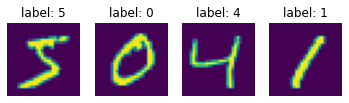

In [5]:
def show_examples(dataset: Dataset, num_examples: int = 4):
    fig, ax = plt.subplots(1, num_examples)
    
    for i in range(num_examples):
        img, label = dataset[i]
        ax[i].imshow(img[0])
        ax[i].set_title(f'label: {label}')
        ax[i].axis('off')
    plt.show()
    
    
show_examples(dataset=mnist_train)

## Задание 1
**(0.5 балла)** Напишите свою версию датасета, который будет читать картинки с диска.  
Подразумевается, что если вы написали свой датасет, то он будет использоваться при обучении вместо дефолтного `MNIST`.  

В ячейках ниже сгенерится датасет в таком формате:
- /MNIST_image_folder
    - /train.csv
    - /train/{class_name}/{image_name}.png
    - /val.csv
    - /val/{class_name}/{image_name}.png

CSV файлы содержат название файла и его лейбл: `image`, `label`.

*Hint 1:* нужно унаследоваться от класса `Dataset` и переопределить методы `__getitem__` и `__len__`.
Первый должен возвращать картинку и ее лейбл, а второй количество примеров в датасете.
(На самом деле второй метод не обязателен для самого датасета, но он необходим для
[семплера](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler),
который используется даталоадером)
(см. [PyTorch docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset),
[PyTorch tutorual](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset))  
*Hint 2:* для работы с картинками лучше использовать OpenCV: `pip install opencv-python-headless`.
В частности [cv2.imread](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56).  
*Hint 3:* обратите особое внимание на то, что возвращает функция `cv2.imread` (пример загрузки изображения с помощью cv2 есть в семе)


In [6]:
import pickle
import numpy as np
import os
import cv2
from collections import Counter
from tqdm.auto import tqdm
import pandas as pd

def generate_image_folder_dataset(dataset, target_path, csv_path):

    images_counter = Counter()

    files = []
    labels = []

    for image, label in tqdm(dataset):
        class_folder = target_path + "/" + str(label)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder, exist_ok=True)

        images_counter[label] += 1
        file_name = f"/{images_counter[label]:05}.png"
        full_image_file_name = class_folder + file_name

        files.append(str(label) + file_name)
        labels.append(label)

        image = np.array(image)
        image = (image * 255).astype(np.uint8)
        image = np.transpose(image, [1, 2, 0])
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # print(image.dtype)
        # print(image.shape)
        cv2.imwrite(full_image_file_name, image)

        # break
    pd.DataFrame({ "image": files, "label": labels }).to_csv(csv_path, index=False)

generate_image_folder_dataset( mnist_train,  "./MNIST_image_folder/train", "MNIST_image_folder/train.csv" )
generate_image_folder_dataset( mnist_val,  "./MNIST_image_folder/val", "MNIST_image_folder/val.csv" )

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
image_labels = pd.read_csv('./MNIST_image_folder/train'+'.csv')

In [9]:
image_labels

,image,label
0,5/00001.png,5
1,0/00001.png,0
2,4/00001.png,4
3,1/00001.png,1
4,9/00001.png,9
...,...,...
59995,8/05850.png,8
59996,3/06131.png,3
59997,5/05421.png,5
59998,6/05918.png,6


In [21]:
a = cv2.imread('./MNIST_image_folder/train/8/05851.png')

In [27]:
# a[:, :, 2]

Теперь можно написать свой класс датасета для тех файлов, которые мы сгенерили

In [42]:
%%write_and_run dataset_mnist.py 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
import os

class DatasetMNIST(Dataset):
    def __init__(self, root='./MNIST_image_folder', train=True, transform=None):
      if train:
        self.path_to_files = root + '/train'
      else:
        self.path_to_files = root + '/val'
      self.image_labels = pd.read_csv(self.path_to_files+'.csv')
      self.transform = transform

    def __len__(self):
      return len(self.image_labels)

    def __getitem__(self, idx):
      # load image
      # transform image
      # return dict with image and class label

      # todo
      img_path = os.path.join(self.path_to_files, self.image_labels.iloc[idx, 0])
      image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      label = self.image_labels.iloc[idx, 1]

      if self.transform:
          image = self.transform(image)
      return {
          'image': image, 
          'label': label
          }


тест класса датасета

In [43]:
def test_dataset(dataset, test_name=""):

    assert len(dataset) > 0, f"{test_name}: dataset length is greater then zero"

    idateset = iter(dataset)
    item = next(idateset)

    assert isinstance(item, dict), f"{test_name}: dataset returned dict"
    assert "image" in item, f"{test_name}: dataset item dict has image"
    assert "label" in item, f"{test_name}: dataset item dict has label"

    assert item['image'].shape == (1, 28, 28), f"{test_name}: dataset image shape is correct. Got: {item['image'].shape}"

mydataset = DatasetMNIST(train=False, transform=transform_to_tensor)
test_dataset(mydataset, test_name="val")

mydataset = DatasetMNIST(train=True, transform=transform_to_tensor)
test_dataset(mydataset, test_name="train")

In [44]:
a = next(iter(mydataset))

In [124]:
a['image'].unsqueeze(1)[0].reshape(28, 28).shape

torch.Size([28, 28])

## Задание 2
**(0.3 балла)** Напишите класс MLP сети из 3 линейных слоев, которая будет получать на вход
батч картинок размера [BS, C, H, W]

*Hint 1:* метод `.flatten(start_dim=1)` поможет вытянуть картинку в вектор.  
*Hint 2:* выход должен соответствовать количеству лейблов, то есть 10.  
*Hint 3:* пачка линейных слоев подряд не имеет смысла без нелинейностей между ними. Попробуйте разные слои нелинейности (один слой на один эксперимент): `ReLU`, `LeakyReLU`, `Tanh` ... [Другие](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

In [131]:
%%write_and_run custom_mlp.py 

# важно! все зависимости, которые используете (если добавляее новые) в этом классе надо явно продублировать в эту ячейку
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomMLP(nn.Module):
    def __init__(self,
                 num_pixels_per_img: int = 784,  # 28*28 == 784
                 ):
        super().__init__()
        self.input_size = num_pixels_per_img

        # here you can init layers and stack them with nn.Sequential
        self.inner = nn.Sequential(
            nn.Linear(self.input_size, 32*8),
            nn.BatchNorm1d(num_features=32*8),
            nn.ReLU(),
            nn.Linear(32*8, 32*4),
            nn.BatchNorm1d(num_features=32*4),
            nn.ReLU(),

            nn.Flatten(1),
            nn.Linear(32*4, 10),
        )

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']
        x = x.unsqueeze(1).reshape(-1, self.input_size)
        print(x.shape)
        logits = self.inner(x) # [ bs, 10 ]
        assert logits.size() == torch.Size([ x.size(0), 10 ]), f"logits size is wrong: {logits.size}"
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

## Задание 3
**(0.3 балла)** Напишите класс CNN сети из 3 сверточных слоев.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* описание сверточных слоев [PyTorch docs](https://pytorch.org/docs/stable/nn.html#convolution-layers). Нам нужен `Conv2d`

Тут тоже можете поэксперементировать с разными слоями активации.

Чтобы было проще считать размерности для конечного слоя, используйте `kernel_size=3, padding=1` в сверточных слоях

In [166]:
%%write_and_run custom_cnn.py 

# важно! все зависимости, которые используете (если добавляее новые) в этом классе надо явно продублировать в эту ячейку
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self,
                 num_pixels_per_img: int = 784,  # hint: 28*28 == 784
                 ):
        super().__init__()

        # here you can init layers and stack them with nn.Sequential
        self.inner = nn.Sequential(
            # [ bs, ch, w, h ]
            nn.Conv2d(1, 8, kernel_size=3, padding=1), # [ bs, 8, w, h ]
            nn.ReLU(),
            nn.Conv2d(8, 3, kernel_size=3, padding=1), # [ bs, 3, w, h ]
            nn.ReLU(),

            nn.Flatten(1), # [ bs, 3 * w * h ]
            nn.Linear(3 * 28 * 28, 10), # [ bs, 10 ]
        )

    def forward(self, x):
        # describe usage of layers here, be careful with input shape
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']
        x = x.reshape(-1, 28, 28).unsqueeze(1)
        logits = self.inner(x) # [ bs, 10 ]
        assert logits.size() == torch.Size([ x.size(0), 10 ]), f"logits size is wrong: {logits.size}"
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

## Задание 4
**(0.3 балла)** Напишите класс CNN сети из 3 блоков с добавлением skip-connection блока
(ResNet [paper](https://arxiv.org/abs/1512.03385)).  
**(0.3 балла)** Реализовать residual блок в отдельном классе `ResBlock`.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* пример skip-connection:  
![image](https://i1.wp.com/dangminhthang.com/wp-content/uploads/2020/06/resnet-block.jpg?fit=400%2C225)

In [183]:
%%write_and_run custom_resnet.py 

# важно! все зависимости, которые используете (если добавляее новые) в этом классе надо явно продублировать в эту ячейку
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        """
        in_dim --- размерность слоев на входе (используется в nn.Conv2d)
        hidden_dim --- скрытая размерность слоев (используется в nn.Conv2d)
        """

        self.model = nn.Sequential(
            nn.Conv2d(in_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, in_dim, kernel_size=3, padding=1),
        )

        self.activation = nn.ReLU()

        return

    def forward(self, x):
        
        conved = self.model(x)

        return self.activation(x + conved)


class CustomResNet(nn.Module):
    def __init__(self,
                 num_pixels_per_img: int = 784,  # hint: 28*28 == 784
                 ):
        super().__init__()

        # here you can init layers and stack them with nn.Sequential
        self.inner = nn.Sequential(
            # [ bs, ch, w, h ]
            ResBlock(1, 4),
            nn.ReLU(),
            ResBlock(1, 8),
            nn.ReLU(),

            nn.Flatten(1),
            nn.Linear(1 * 28 * 28, 10),
        )

    def forward(self, x):
        # describe usage of layers here, be careful with input shape
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']
        x = x.reshape(-1, 28, 28).unsqueeze(1)
        logits = self.inner(x) # [ bs, 10 ]
        assert logits.size() == torch.Size([ x.size(0), 10 ]), f"logits size is wrong: {logits.size}"
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

## Задание 5
**(0.3 балла)** Инициализируйте и обучите сети из пунктов 1, 2, 3, используя класс `Trainer` из семинара.

В тренерене, возможно, вы захотите писать больше метрик: лосс во время трейна, валидационный лосс, валидационные метрики (можно префиксовать валидационные метрики с помощью "val", чтобы не путались)

Каждая модель должна побить определенные пороги кач-ва (> 0.8 за 3 эпохи)

In [170]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [144]:
from torch.utils.tensorboard import SummaryWriter
import torch

class Trainer:
    def __init__(self, model: nn.Module, optimizer,
                 train_dataset: Dataset, val_dataset: Dataset,
                 tboard_log_dir: str = './tboard_logs/', batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)


    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        train_losses = []
        train_accs = []
        val_losses_plot = []
        val_accs_plot = []
        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                # print(batch)
                loss, metrics = model.compute_all(batch)
                train_losses.append(loss.item())
                train_accs.append(metrics['acc'])

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in metrics.items():
                    self.log_writer.add_scalar(k + "/train", v, global_step=self.global_step)
                self.global_step += 1

            with torch.no_grad():
                model.eval()
                val_losses = []
                val_accs = []
                for batch in tqdm(val_loader):
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    loss, metrics = model.compute_all(batch)
                    for k, v in metrics.items():
                        self.log_writer.add_scalar(k + '/validation', v, global_step=self.global_step)
                    val_losses.append(loss.item())
                    val_accs.append(metrics['acc'])

                val_loss = np.mean(val_losses)
                val_acc = np.mean(val_accs)
                if val_loss < best_loss:
                    self.save_checkpoint("./best_checkpoint.pth")
                    best_loss = val_loss
            
            steps = self.train_dataset.image_labels.shape[0] / self.batch_size
            val_losses_plot.append((steps * (epoch + 1), val_loss))
            val_accs_plot.append((steps * (epoch + 1), val_acc))

            clear_output()
            plot_history(train_losses, val_losses_plot, title='loss')
            plot_history(train_accs, val_accs_plot, title='accuracy')
            
            print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(val_loss,val_acc, epoch))

#### CustomMLP

In [112]:
model = CustomMLP()
opt = optim.SGD(model.parameters(), lr=3e-3)

mnist_train = DatasetMNIST(train=True, transform=transform_to_tensor)
mnist_val = DatasetMNIST(train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, mnist_train, mnist_val, batch_size=128)

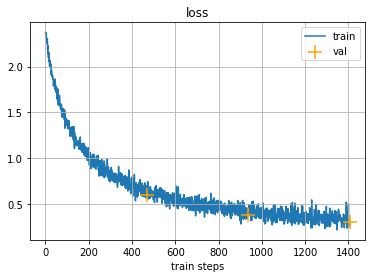

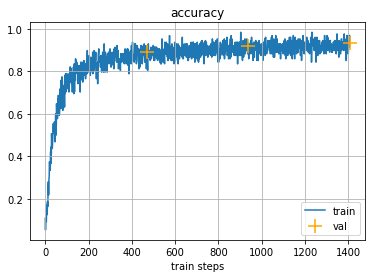

Epoch: 2, val loss: 0.3055641463474382, val accuracy: 0.933445394039154


In [113]:
trainer.train(3)
torch.save(model.state_dict(), "custom_mlp.pt") # важно сохранить веса обученой модели!

#### CustomCNN

In [167]:
model = CustomCNN()
opt = optim.SGD(model.parameters(), lr=3e-3)

mnist_train = DatasetMNIST(train=True, transform=transform_to_tensor)
mnist_val = DatasetMNIST(train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, mnist_train, mnist_val, batch_size=128)

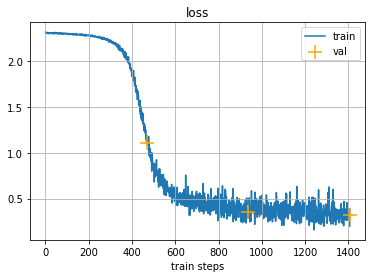

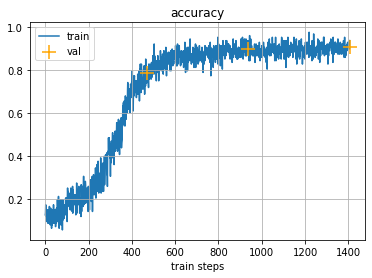

Epoch: 2, val loss: 0.3245884102733829, val accuracy: 0.9079311490058899


In [168]:
trainer.train(3)
torch.save(model.state_dict(), "custom_cnn.pt")  # важно сохранить веса обученой модели!

#### CustomResNet

In [184]:
model = CustomResNet()
opt = optim.SGD(model.parameters(), lr=3e-3)

mnist_train = DatasetMNIST(train=True, transform=transform_to_tensor)
mnist_val = DatasetMNIST(train=False, transform=transform_to_tensor)

trainer = Trainer(model, opt, mnist_train, mnist_val, batch_size=128)

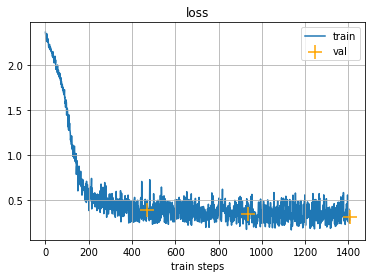

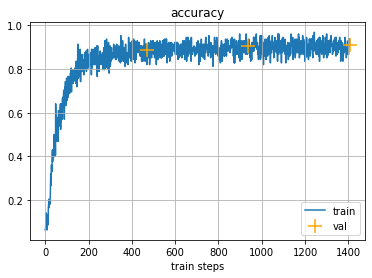

Epoch: 2, val loss: 0.3121208295791964, val accuracy: 0.910007894039154


In [185]:
trainer.train(3)
torch.save(model.state_dict(), "custom_resnet.pt") # важно сохранить веса обученой модели!

### Тест


In [186]:
import pytest
import torch
import torch.nn as nn

import sys

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

mnist_val = MNIST(root='./', train=False, download=True, transform=transform_to_tensor)

def _test_model(model, target_accuracy, flatten=True):
    print(model)

    dataloader = DataLoader(mnist_val, batch_size=128)

    all_logits = []
    all_labels = []

    with torch.no_grad():

        for images, labels in dataloader:
            if flatten:
                images = images.flatten(1)
            logits = model(images)
            all_logits.append(logits)
            all_labels.append(labels)

        all_logits = torch.cat(all_logits)
        all_labels = torch.cat(all_labels)

        print(all_logits.shape, all_labels.shape)

        accuracy = (all_logits.argmax(axis=1) == all_labels).float().mean().cpu().numpy()
        print("accuracy", accuracy)

        assert accuracy > target_accuracy

def test_model_mlp():
    from custom_mlp import CustomMLP

    cmlp = CustomMLP()
    cmlp.load_state_dict( torch.load("custom_mlp.pt") )
    cmlp.eval()

    _test_model(cmlp, 0.8, flatten=True)

def test_model_cnn():
    from custom_cnn import CustomCNN

    ccnn = CustomCNN()
    ccnn.load_state_dict( torch.load("custom_cnn.pt") )
    ccnn.eval()

    _test_model(ccnn, 0.8, flatten=False)


def test_model_resnet():
    from custom_resnet import CustomResNet

    cresnet = CustomResNet()
    cresnet.load_state_dict( torch.load("custom_resnet.pt") )
    cresnet.eval()

    _test_model(cresnet, 0.8, flatten=False)


test_model_mlp()
test_model_cnn()
test_model_resnet()

CustomMLP(
  (inner): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=128, out_features=10, bias=True)
  )
)
torch.Size([10000, 10]) torch.Size([10000])
accuracy 0.9334
CustomCNN(
  (inner): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=2352, out_features=10, bias=True)
  )
)
torch.Size([10000, 10]) torch.Size([10000])
accuracy 0.9076
CustomResNet(
  (inner): Sequential(
    (0): ResBlock(
      (model): Sequenti

#### Не забываем смотреть в тензорборд

In [187]:
%load_ext tensorboard

In [188]:
%tensorboard --logdir ./tmp

<IPython.core.display.Javascript object>